# EE5175 Lab 6 : Shape From Focus
### Author : Niyas Mon P
### Roll No: EE20B094

In [249]:
# Before running the code blocks, please ensure that all the required files are uploaded

In [250]:
# importing necessary libraries
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import cv2

### Load the image stack

In [251]:
# load the stack
frames = loadmat('stack.mat')
# extracting the image frames
frames = {frame_num: frame for i, (frame_num, frame) in enumerate(frames.items()) if i >= 4 and i<104}
# converting the image frames into list
frames = list(frames.values())

### Zero padding (For performing convolution)
* Zero padding is needed around the image inorder to perform the 2D convolution operation. And number of pixels padded on one side will be '$n$' if kernel size is '$2n+1$'.
* The padding is done inorder to make sure that when convolution of peripheral pixels are done with kernel, the the kernel values sitting outside the image are getting multiplied with zero.

In [252]:
# return a zero padded image required for convolution
def pad(image,kernel_size):

  # kernel_size = kernel.shape[0]
  # no of zero padding on one side will be 'n' if kernel size is '2n+1'
  pad_size    = kernel_size//2
  # dimensions of original image
  ht, wd      = image.shape

  # if the kernel size is 1, the no need for padding
  if kernel_size == 1:
    return image

  # zero padding
  padded_image = np.zeros((ht+ 2*pad_size,wd+ 2*pad_size))
  padded_image[pad_size:-pad_size,pad_size:-pad_size] = image

  return padded_image

## **2D convolution**
* ### Used for doing **Modified Lapacian** and **Sum Modified Laplacian** operations
#### Following function takes the image and the kernel as the inputs and outputs the convolved image.

In [253]:
# 2D convolution with kernel :-> Space Invariant Blur
def conv2D(image,kernel):

  # abstracting image size and kernel size
  img_ht , img_wd = image.shape
  kernel_size     = kernel.shape[0]

  # if kernel size is 1, then output will be the image multiplied by the kernel value
  if kernel_size == 1:
    return image * kernel[0,0]

  # zero padding
  padded_image    = pad(image,kernel_size)
  # creating a blank image for output
  output_image    = np.zeros_like(image,dtype=float)

  for n in range(img_ht):
    for m in range(img_wd):
      # 2D convolution with kernal
      conv2d_val        = np.sum(padded_image[n:n+kernel_size,m:m+kernel_size] * kernel, axis=None)
      output_image[n,m] = conv2d_val

  return output_image


## **Modified Laplacian (ML)**
Modified Laplacian ($ML$) operator is given by as follows.

$$
ML(\underline{x}) = \sum_{\substack{\underline{z} \in W(\underline{x})}} |f_{xx}(\underline{z})|+|f_{yy}(\underline{z})|
$$


where $f_{xx}$ and $f_{yy}$ are the discrete double derivative operators which is in the form of 3x3 matrices which then convolved with the image to produce ML

$$
f_{xx} = \begin{align*}
\begin{bmatrix}
0 & 0 & 0 \\
1 & -2 & 1 \\
0 & 0 & 0 \\
\end{bmatrix}
\end{align*}
$$

$$
f_{yy} = \begin{align*}
\begin{bmatrix}
0 & 1 & 0 \\
0 & -2 & 0 \\
0 & 1 & 0 \\
\end{bmatrix}
\end{align*}
$$



In [254]:
def ModifiedLaplacian(image):
  # second derivative kernel along x axis
  fxx = np.array([[0,0,0],
                 [1,-2,1],
                 [0,0,0]])
   # second derivative kernel along y axis
  fyy = np.array([[0,1,0],
                 [0,-2,0],
                 [0,1,0]])

  # perfoming the second derivative calculation using convoluion
  Ixx = conv2D(image,fxx)
  Iyy = conv2D(image,fyy)

  # taking absolute sum to get ML
  ML  = np.abs(Ixx) + np.abs(Iyy)

  return ML


## **Sum Modified Laplacian (SML)**

In Sum Modified Laplacian ($SML$), we calculate SML by summing the neighbourhood ML values for each pixel. Here **'q'** is the size of the neighbourhood for the SML window

$$
SML[f(x,y)] = \Sigma_{i=x-q}^{i=x+q}\Sigma_{j=y-q}^{j=y+q}ML[f(i, j)]
$$

we use q = 0, 1 and 2.

In [255]:
def SumModifiedLaplacian(image,q):
  # performing ML first
  ML = ModifiedLaplacian(image)
  # defining the neighbourhood kernel
  sum_kernel = np.ones((2*q+1,2*q+1))

  # summing the neighbourhood values to get SML
  SML = conv2D(ML,sum_kernel)
  return SML

#### ***get_focal_measure*** function performs SML for all the frames and return the SML values for all the frames

In [256]:
def get_focal_measure(frames,q):
  SML = [] # list to store the SML values of each frame in the stack
  for frame in frames:
    # performing SML for each frame
    SML.append(SumModifiedLaplacian(frame,q))

  return np.array(SML)

## Gaussian fit for depth calculation

We do gaussian interplotation for the peak 3 points.
Let $F_{m}$ be the peak focal measure and $F_{m-1}$ and $F_{m+1}$ be the nearer values on either side correspinding to the depths of $d_{m}$, $d_{m-1}$ and $d_{m+1}$.

The depth of field is given by $Δd$. \\
Then the depth using gaussian interpolation is given by,
$$
\overline{d} = \underline{(ln(F_{m}) - ln(F_{m-1})) (d_{m+1}^2-d_m^2) - (ln(F_{m}) - ln(F_{m+1}))(d_{m-1}^2-d_m^2)}
$$
$$
2 \cdot Δd ⋅ (2 ⋅ ln(F_{m}) - ln(F_{m+1}) - ln(F_{m+1}))
$$

In [257]:
def fit_gaussian(fm1,fm2,fm3,m1,m2,m3,delta_d):
  # depths of peak 3 values
  dm1 = m1*delta_d
  dm2 = m2*delta_d
  dm3 = m3*delta_d

  # gaussian interpolation
  depth = (np.log(fm2) - np.log(fm1))*(dm3**2 - dm2**2) - ((np.log(fm2) - np.log(fm3))*(dm1**2 - dm2**2))
  depth = depth / (2*delta_d*(2*np.log(fm2)-np.log(fm3)- np.log(fm1)))

  return depth

## Depth calculation from the Focal measures obtained by SML

We choose the depth where the focal measure is maximum (after gaussian interpolation of peak 3 points )

In [262]:
def get_depth(focal_measures,delta_d):
  # storing the index of the frame at which the focal measure is maximum for each pixel
  # size of 'max_indices' with be the size of the image
  max_indices = np.argmax(focal_measures, axis=0)
  # getting number of frames and image size
  num_frames,m,n = focal_measures.shape

  # defining an array to store the depth of each pixel
  depth_array = np.zeros_like(max_indices)

  # for each pixel:
  for i in range(m):
    for j in range(n):

      m = max_indices[i,j] #index at which focal measure is maximum for this pixel

      # if it is corner case, return the depth without gaussian interpolation
      if m== 0 or m == num_frames-1:
        depth = m * delta_d

      else:
        # focal measures of the peak points
        fm1 = focal_measures[m-1,i,j]
        fm2 = focal_measures[m,i,j]
        fm3 = focal_measures[m+1,i,j]
        # if all the 3 peak values are same, we don't have to do gaussian interpolation
        # else we do gaussian interpolation
        if fm1 == fm2 == fm3:
          depth = m * delta_d
        else:
          depth = fit_gaussian(fm1,fm2,fm3,m-1,m,m+1,delta_d)

      depth_array[i,j] = depth

  return depth_array


## Plots
### q = 0, 1 and 2

In [259]:
## performing SML and depth calculation for q = 0,1 and 2

delta_d = 50.50 # depth of field
q_vals = [0,1,2]
depth_q = [] # list to store depths for each value of q

for q in q_vals:
  # focal measures
  focal_measures = get_focal_measure(frames, q)
  # Depth calculation
  depth_q.append(get_depth(focal_measures, delta_d))


3D depth map for q=0,1 and 2


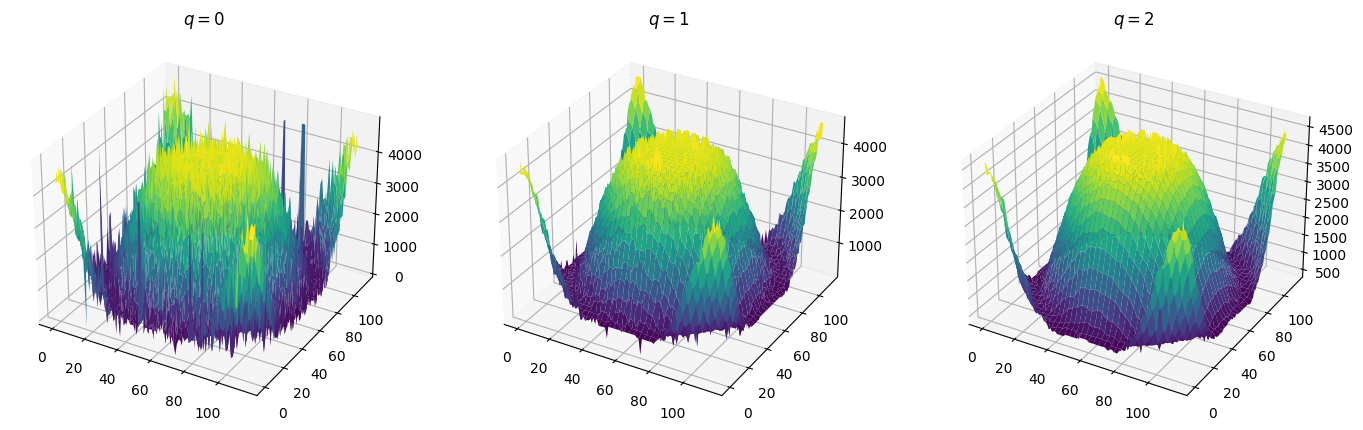

In [260]:
print("\n3D depth map for q=0,1 and 2")
print("==============================")
fig, axs = plt.subplots(1, 3, figsize=(17, 7), subplot_kw={'projection': '3d'})

for i,q in enumerate(q_vals):
    # 3D Plot
    x = np.arange(depth_q[i].shape[0])
    y = np.arange(depth_q[i].shape[1])
    X, Y = np.meshgrid(x, y)
    ax = axs[i]
    surf = ax.plot_surface(X, Y, depth_q[i], cmap='viridis')
    ax.set_title(f"$q = {q}$")

## Inferences

* As the neighbourhood(q) increases, we get smoother depth map. However we should not go for much higher q values as it will average out the depth values.
* The depth of field ($Δd$) of the camera is 50.50. Hence, using this we get depth estimate with integer multiples of $Δd$. To get more accurate depth map, we use Gaussian interpolation among the 3 peak values.